## MiniProject
- Objective 1: 직접 ARIMA를 통해 시계열 예측을 수행
- Objective 2: 직접 ARCH를 통해 S&P500의 변동성을 모델링

#### 01. ARIMA로 AirPassenger데이터 예측
- 일단 package 버전 충돌 문제로 Numpy 버전 다운그레이드
- 실제 업무에서는 docker등으로 별도의 환경 구성해서 분석

In [1]:
# 먼저 NumPy를 다운그레이드 - 세션다시시작 누르기
!pip install numpy==1.23.5 # --force-reinstall

In [2]:
# 그다음 pmdarima 재설치
!pip install pmdarima # --force-reinstall

In [4]:
!pip install arch==6.3.0 # 패키지 버전 지정도 가능!

##### ① 데이터 불러오기

In [5]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
ap = pd.read_csv(url)
ap.drop('Month', axis = 1, inplace = True)
print(ap.head())

   Passengers
0         112
1         118
2         132
3         129
4         121


##### ② ARIMA 실습해보기!

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf_plot 및 pacf plot 그리기
from statsmodels.tsa.arima_model import ARIMA # ARIMA (p,d,q) (AR의 p, 차분 d, MA의 q)
import pmdarima as pm # Auto ARIMA 모델

In [8]:
import pmdarima, scipy, statsmodels
print("pmdarima:", pmdarima.__version__)
print("scipy:", scipy.__version__)
print("statsmodels:", statsmodels.__version__)

pmdarima: 2.0.4
scipy: 1.15.3
statsmodels: 0.14.4


##### ③ 데이터 확인하기

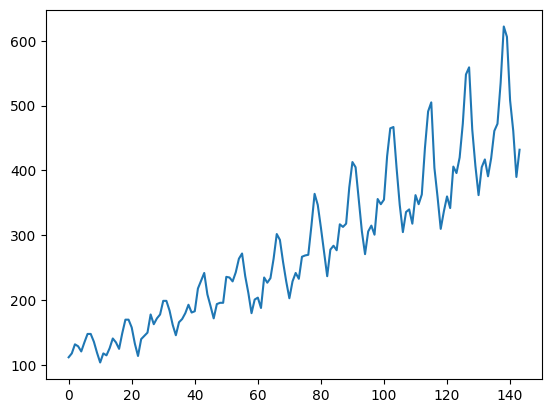

In [11]:
plt.plot(ap)
plt.show()

##### ④ 분산을 일정하게 만들기 - log transformation

In [12]:
# np.log를 통해서 log transformation
ap_transformed = np.log(ap)

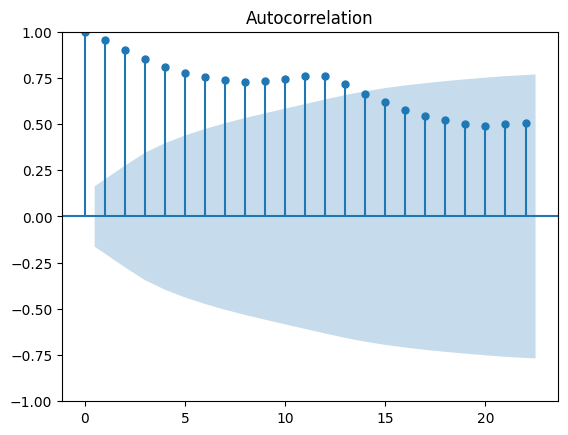

In [13]:
plot_acf(ap_transformed) # acf plot, 점차 감소하는 모양새를 지니고 있음
plt.plot();

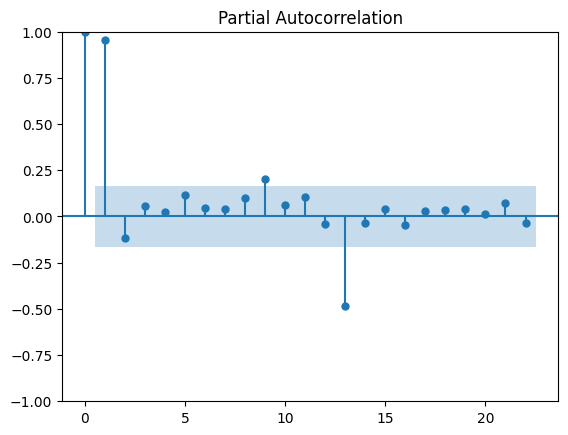

In [14]:
plot_pacf(ap_transformed) # pacf plot, lag 2까지 유의미한 결과를 보임
plt.plot();

##### ⑤ 차분을 통해 분석하기

In [15]:
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()

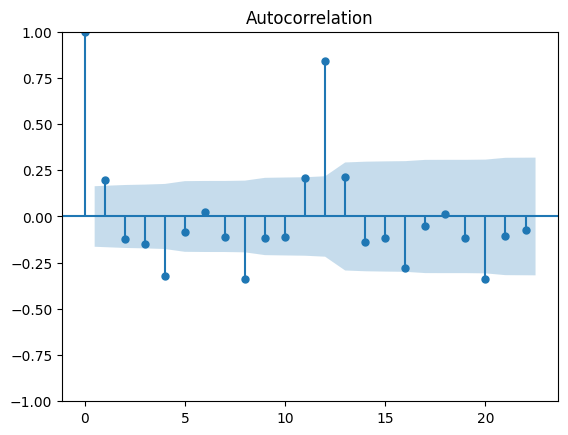

In [16]:
# lag 1과 lag 12에서 유의미한 lag가 포착됨
plot_acf(ap_diff)
plt.plot();

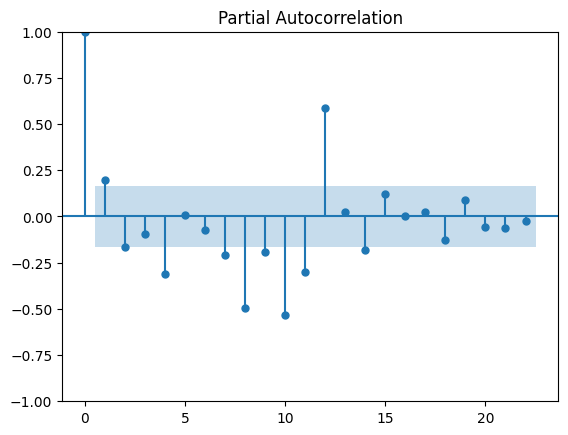

In [17]:
# lag 1, lag 8~12쯤에서 유의미한 lag가 포착됨
plot_pacf(ap_diff)
plt.plot();

In [18]:
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed[train_size:]

##### ⑥ Auto ARIMA 적용 및 결과 확인

In [21]:
# AutoARIMA
# seasonal = True, max_D(계절차분) = 12

import warnings
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12)
  res = model.fit(ap_transformed_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-212.317, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-216.578, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-219.761, Time=2.98 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-200.633, Time=0.93 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-219.665, Time=0.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-198.633, Time=0

In [22]:
# confidence interval까지 도출
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True)

# 아래의 코드 결과값을 서로 비교 분석해봅시다.
print(preds.shape)
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))
print('--'*40)
print(preds)
print('--'*40)
print(conf_int)

(29,)
<class 'pandas.core.series.Series'>
--------------------------------------------------------------------------------
29
<class 'int'>
--------------------------------------------------------------------------------
115    6.198793
116    6.136151
117    6.082282
118    6.040516
119    6.039927
120    6.057910
121    6.088662
122    6.116508
123    6.137019
124    6.149596
125    6.156885
126    6.162866
127    6.169829
128    6.179026
129    6.190072
130    6.202157
131    6.214364
132    6.226152
133    6.237376
134    6.248170
135    6.258781
136    6.269414
137    6.280179
138    6.291085
139    6.302083
140    6.313110
141    6.324119
142    6.335090
143    6.346027
dtype: float64
--------------------------------------------------------------------------------
[[6.03361594 6.36396945]
 [5.90570482 6.36659627]
 [5.83732125 6.3272426 ]
 [5.79197026 6.2890615 ]
 [5.7903805  6.28947285]
 [5.80705915 6.30876054]
 [5.83641536 6.34090888]
 [5.86418057 6.36883494]
 [5.88456322 6.3894

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


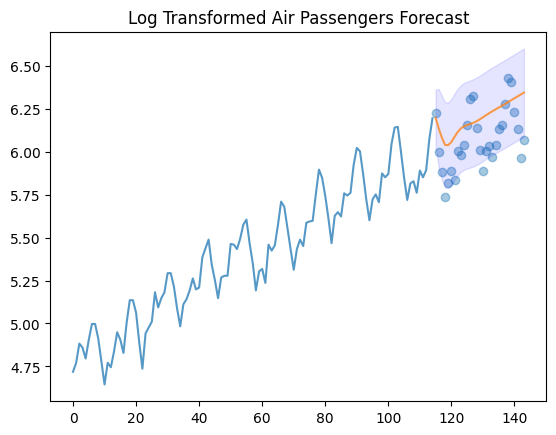

In [23]:
# 예측 성능을 시각화합니다.
# 0. train과 test data를 축(axis)으로 만들었습니다.
# 1. x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화 합니다.
# 2. 1번 그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성됩니다.
# 3. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성합니다.
# 4. 2, 3번의 분포에 해당하는 구간을 채워 그래프로 나타냈습니다.
x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 115 + 29, plot을 그리기 위해 x축을 생성합니다. # 0
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # 1
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # 2
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test,
            alpha=0.4, marker='o')  # 3 기존 test data는 scatter
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 4
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목
plt.show() # 4개의 plot을 시각화 합니다.

#### 02. ARCH모델 실습
- S&P500 데이터 활용해서, ARCH모델 적용해보기
- 수익률 자체는 직접 예측못하더라도(효율적 시장 가설), 수익률의 변동성은 예측할 수 있다는데 의의가 있음(파생상품의 리스크 등)

##### ⑦ ARCH 모델 실습해보기

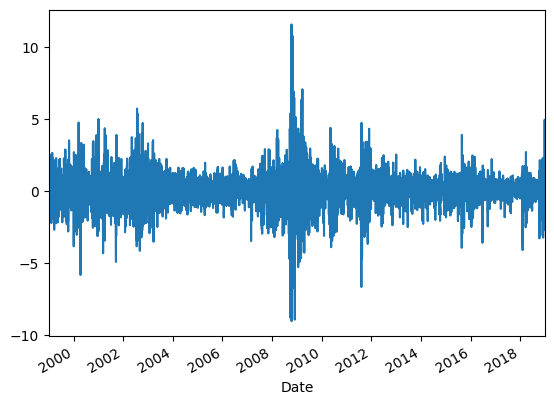

In [24]:
# ⑦-1 : 데이터 및 라이브러리 불러오기
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리 입니다 .
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러옵니다.

# ⑦-2 : 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) # start date
en = dt.datetime(2022, 1, 1) # end date
data = arch.data.sp500.load() # s&p 500 데이터 불러오기
market = data["Adj Close"] # 종가만 활용
returns = 100 * market.pct_change().dropna() # return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한 합니다.
plt.show()

In [26]:
# ⑦-3 : ARCH 모델 적용
from arch import arch_model

am = arch_model(returns) # return을 arch모델에 적합
res = am.fit(update_freq=5)

# ⑦-4 : 지표를 통한 결과 확인
print(res.summary())
# 다양한 결과가 제시되어있으나, 수업때 배웠던 p-value, AIC, BIC위주로 내용을 파악
# 아래에 있는 volatility model을 보면 alpha[1], Beta[1]은 GARCH(1,1)을 의미하며, p-value를 통해 신뢰도 95%에서 이들이 유의미함을 도출

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Mon, May 26 2025   Df Residuals:                     5029
Time:         

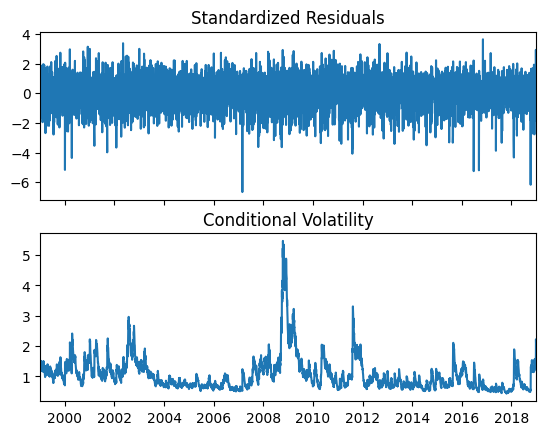

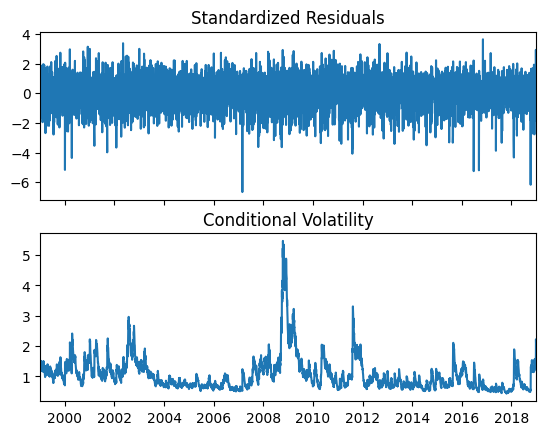

In [27]:
# ⑦-5 : 시각화를 통한 결과값 확인
res.plot()

#### 간단한 Reflection
- 일단 pmdarima 이 라이브러리와 numpy간의 버전 충돌 문제로 애를 많이 먹었다.
  - 아마 실제 업무 환경이라면, pmdarima를 가져다 쓰는 것보다는 함수를 직접 정의해서 쓰거나, 이 pmdarima에 맞는 버전의 numpy와 여타 패키지 버전의 목록을 정리한 다음, 그 버전에 맞게 컨테이너를 통한 가상환경을 구성해서(docker등을 통해) 활용하는 방식으로 적용해야겠다.
  - 시간이 걸리더라도, 이런 버전 충돌 문제에 대해 빠르게 대응할 수 있게 docker나 컨테이너 등의 활용법등은 따로 숙지를 해야 할 것 같음.

- 강의 노드에서는 arch 모델이 '수익률'자체보다는 '변동성'을 예측하는데 의의가 있다고 하니까 파생상품이나, VAR(Value at Risk) 같은 것을 예측하는 상황 등의 사례를 더 찾아보거나 공부해 볼 필요가 있을 것 같음.